# 特異スペクトル変換法

SVDは周期的な要素の変化に敏感だよ by 永山　

もしかしたら次数の変化とかなら捉えやすいかもね

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from itertools import islice
plt.style.use('seaborn-whitegrid')


### まずはサンプルコード
[特異スペクトル変換法による時系列の異常検知](https://qiita.com/s_katagiri/items/d46448018fe2058d47da#IdeSugiyama2015])

In [2]:
# SSA 用の関数
def window(seq, n):
    """
    window 関数で要素を1づつずらした2次元配列を出す. 戻り値は generator
    """
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [3]:

def SSA_anom(test, traject, w, ncol_t, ncol_h, ns_t, ns_h,
             normalize=False):
    """
    特異スペクトル分析 (SSA) による時系列の特徴づけ
    ARGUMENTS:
    -------------------------------------------------
    test: array-like. テスト行列を作る部分時系列
    tracject: array-like. 履歴行列を作る部分時系列
    ns_h: 履歴行列から取り出す特異ベクトルの数
    ns_t: テスト行列から取り出す特異ベクトルの数
    -------------------------------------------------
    RETURNS:
    3要素のタプル: 
        要素1: 2つの部分時系列を比較して求めた異常度
        要素2, 3: テスト行列・履歴行列をそれぞれの特異値の累積寄与率 
    """
    H_test = np.array(
        tuple(x[:ncol_t] for x in window(test, w))[:w]
    )  # test matrix
    H_hist = np.array(
        tuple(x[:ncol_h] for x in window(traject, w))[:w]
    )  # trajectory matrix
    if normalize:
        H_test = (H_test - H_test.mean(axis=0,
                                       keepdims=True)) / H_test.std(axis=0)
        H_hist = (H_hist - H_hist.mean(axis=0,
                                       keepdims=True)) / H_hist.std(axis=0)
    Q, s1 = np.linalg.svd(H_test)[0:2]
    Q = Q[:, 0:ns_t]
    ratio_t = sum(s1[0:ns_t]) / sum(s1)
    U, s2 = np.linalg.svd(H_hist)[0:2]
    U = U[:, 0:ns_h]
    ratio_h = sum(s2[0:ns_t]) /sum(s2)
    anom = 1 - np.linalg.svd(np.matmul(U.T, Q),
                                     compute_uv=False
                                    )[0]
    return (anom, ratio_t, ratio_h)


In [4]:
def SSA_CD(series, w, lag,
           ncol_h=None, ncol_t=None,
           ns_h=None, ns_t=None,
           standardize=False, normalize=False, fill=True):
    """
    Change Detection by Singular Spectrum Analysis
    SSA を使った変化点検知
    -------------------------------------------------
    w   : window width (= row width of matrices) 短いほうが感度高くなる
    lag : default=round(w / 4)  Lag among 2 matrices 長いほうが感度高くなる
    ncol_h: 履歴行列の列数 
    ncol_t: テスト行列の列数
    ns_h: 履歴行列から取り出す特異ベクトルの数. default=1 少ないほうが感度高くなる
    ns_t: テスト行列から取り出す特異ベクトルの数. default=1 少ないほうが感度高くなる
    standardize: 変換後の異常度の時系列を積分面積1で規格化するか
    fill: 戻り値の要素数を NaN 埋めで series と揃えるかどうか
    -------------------------------------------------
    Returns
    list: 3要素のリスト
        要素1: 2つの部分時系列を比較して求めた異常度のリスト
        要素2, 3: テスト行列・履歴行列をそれぞれの特異値の累積寄与率のリスト
    """
    if ncol_h is None:
        ncol_h = round(w / 2)
    if ncol_t is None:
        ncol_t = round(w / 2)
    if ns_h is None:
        ns_h = np.min([1, ncol_h])
    if ns_t is None:
        ns_t = np.min([1, ncol_t])
    if min(ncol_h, ncol_t) > w:
        print('ncol and ncol must be <= w')
    if ns_h > ncol_h or ns_t > ncol_t:
        print('I recommend to set ns_h >= ncol_h and ns_t >= ncol_t')
    start_at = lag + w + ncol_h
    end_at = len(series) + 1
    res = []
    for t in range(start_at, end_at):
        res = res + [SSA_anom(series[t - w - ncol_t:t],
                              series[t - lag - w - ncol_h:t - lag],
                              w=w, ncol_t=ncol_t, ncol_h=ncol_h,
                              ns_t=ns_t, ns_h=ns_h,
                              normalize=normalize)]
    anom = [round(x, 14) for x, r1, r2 in res]
    ratio_t = [r1 for x, r1, r2 in res]
    ratio_h = [r2 for x, r1, r2 in res]
    if fill == True:
        anom = [np.nan] * (start_at - 1) + anom
    if standardize:
        c = np.nansum(anom)
        if c != 0:
            anom = [x / c for x in anom]
    return [anom, ratio_t, ratio_h]

In [5]:
np.random.seed(42)
T = 24 * 7 * 4
pt = (150, 200, 250)
slope = .01
test = pd.DataFrame(data={'time': range(T), #  pd.date_range('2018-01-01', periods=T),
                          'change': [slope * (t - pt[0]) * (t in range(pt[0], pt[1]) ) +
                                     slope * (pt[1] - pt[0]) * (t in range(pt[1], pt[2])) +
                                     (-slope * (t - pt[2]) + slope * (pt[1] - pt[0])) * (t in range(pt[2], pt[2] + (pt[1] - pt[0]))) for t in range(T)],
                         }).set_index('time')
test['+sin'] = test['change'] + 0.2 * np.sin(
    [2 * np.pi * t / 24.0 * np.pi for t in range(T)])
test['+sin+noise'] = test['+sin'] + np.random.normal(size=T, scale=.01)

In [6]:
test.head()

change      +sin  +sin+noise
time                              
0        0.0  0.000000    0.004967
1        0.0  0.146565    0.145183
2        0.0  0.199451    0.205927
3        0.0  0.124853    0.140083
4        0.0 -0.029547   -0.031888

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11fe974a8>,
      dtype=object)

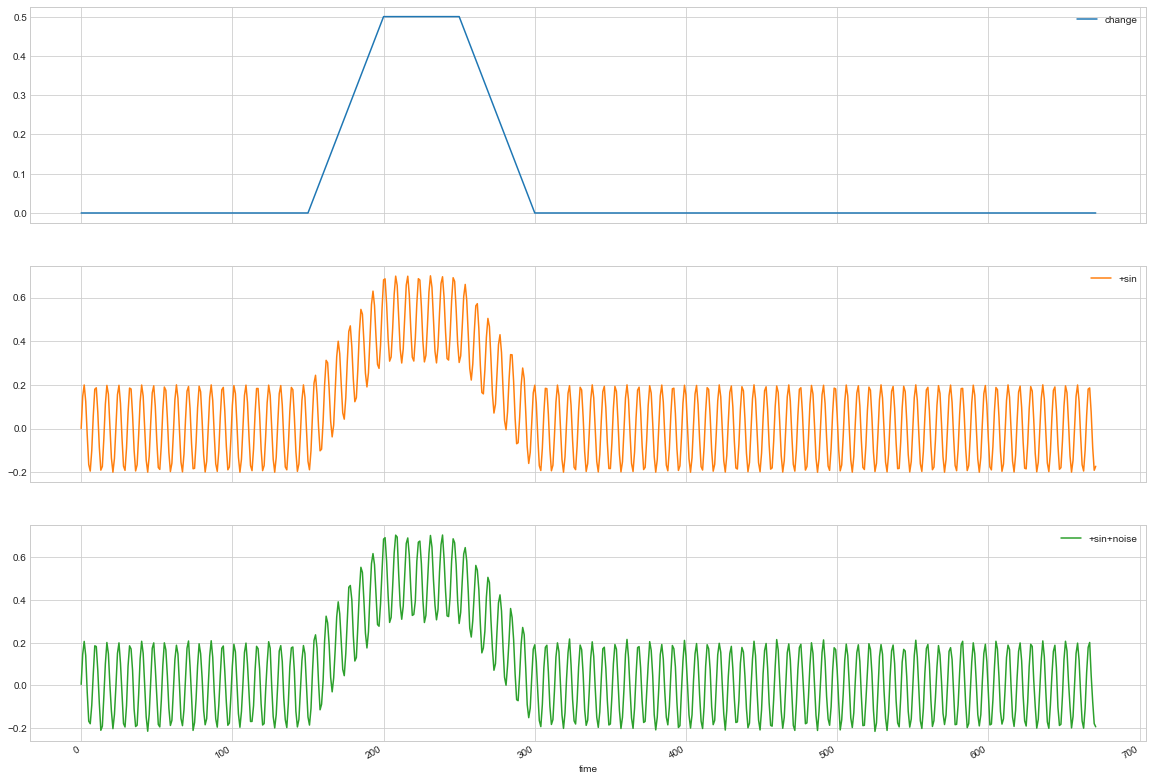

In [7]:
test.plot(subplots=True, figsize=(20, test.shape[1] * 5))

I recommend to set ns_h >= ncol_h and ns_t >= ncol_t


array([<matplotlib.axes._subplots.AxesSubplot object at 0x122669ba8>,
      dtype=object)

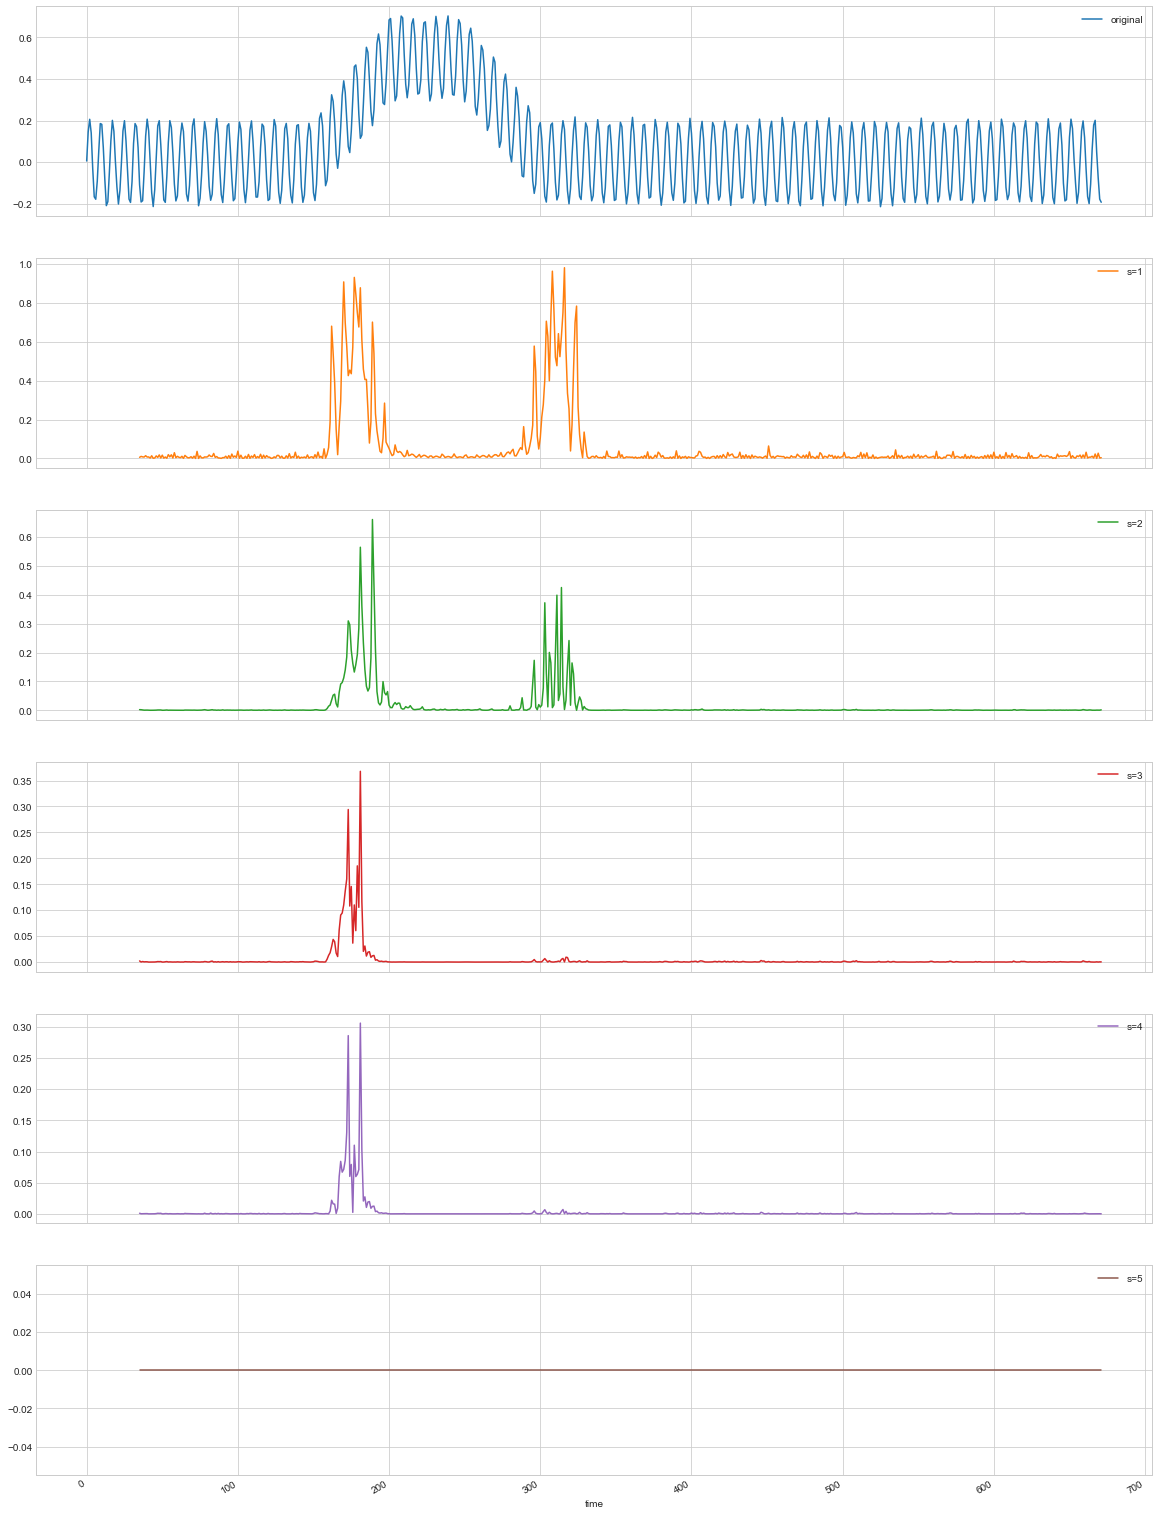

In [8]:
sst = test.copy()
sst = sst[['+sin+noise']]
sst.rename(columns={'+sin+noise': 'original'}, inplace=True)
for s in range(1, 6):
    score = SSA_CD(series=sst['original'].values,
                   standardize=False,
                   w=8, lag=24, ns_h=s, ns_t=1)
    sst['s={}'.format(s)] = score[0]
sst.plot(subplots=True, figsize=(20, sst.shape[1] * 5))

In [9]:
a=np.array(test["+sin+noise"])
SSA_anom(test=a[50:100], traject=a[:50], w=10, ncol_h=40, ncol_t=40, ns_h=1, ns_t=1)

(0.009422079378732295, 0.5278405523059088, 0.5059426575279179)

In [10]:
dists=[]
for i in range(50, len(test)-50):
    target = test[i:i+50]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=a[i:i+50], traject=a[:50], w=10, ncol_h=40, ncol_t=40, ns_h=2, ns_t=1)
    dists.append(dist)

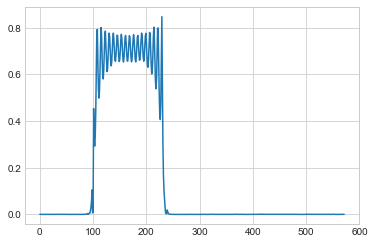

In [11]:
plt.plot(dists)

## 自分のデータでやってみる

In [12]:
import matplotlib.pyplot as plt
import plotly
plotly.offline.init_notebook_mode(connected=False)

import os
path = os.getcwd()
path=path[:path.find('estimate-innovation')+19]
import sys
sys.path.append(path+"/")
import tsModel

正規乱数


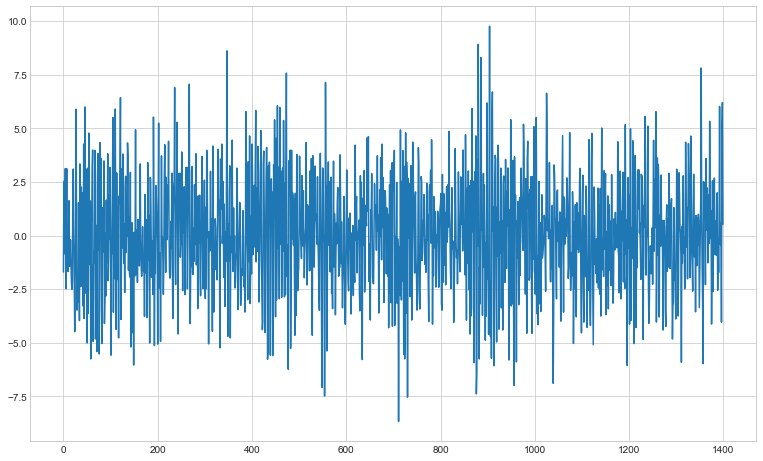

In [13]:
# 人工データの作成
seed=0
Data = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], N=1400, random_seed=seed, sigma=2)
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
# plt.savefig(path+"/images/AR7モデルの人工データその{0}.png".format(seed))

In [14]:
original_window=50
target_window=50
dists0=[]

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1)
    dists0.append(dist)

正規分布＆一様分布


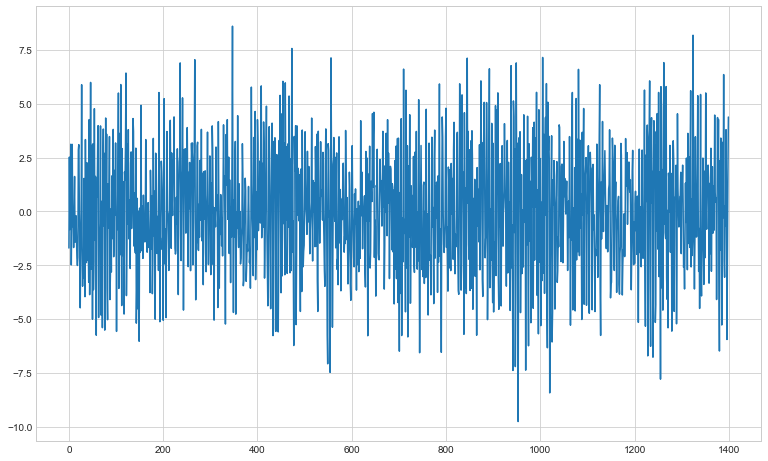

In [15]:
# 人工データの作成
seed=0
Data = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], N=1400, random_seed=seed, sigma=2, randomness="normal&uniform")
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
# plt.savefig(path+"/images/正規分布&一様分布でAR7モデルの人工データその{0}.png".format(seed))

In [16]:
original_window=50
target_window=50
dists1=[]

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1)
    dists1.append(dist)

正規分布＆移動ガンマ分布


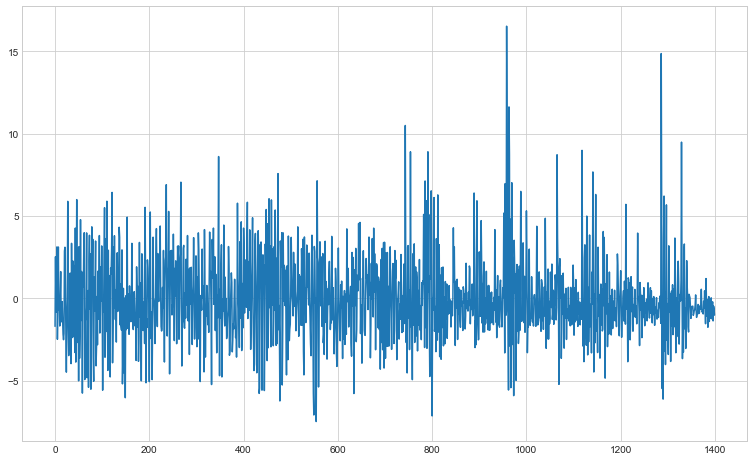

In [17]:
# 人工データの作成
seed=0
Data = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], N=1400, random_seed=seed, sigma=2, randomness="normal&gamma")
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
# plt.savefig(path+"/images/正規分布&移動ガンマ分布でAR7モデルの人工データその{0}.png".format(seed))

In [18]:
original_window=50
target_window=50
dists2=[]

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1)
    dists2.append(dist)

In [32]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists0, name="変化点なし", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists1, name="線形 正規分布から一様分布", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists2, name="線形 正規分布からガンマ分布", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="異常度の変化",
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,1400]},
                yaxis={"title":"value"},
                width = 1000,       # 全体のサイズ
                height = 600,
                )
)
plotly.offline.iplot(fig)

正規乱数
ニューラル


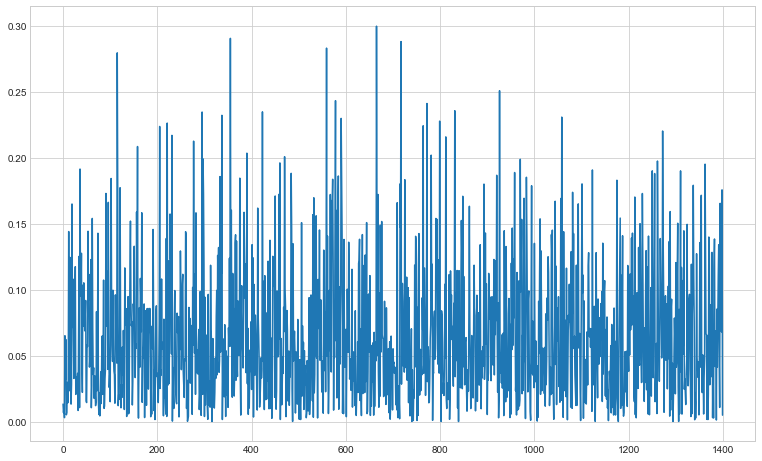

In [20]:
# 人工データの作成
seed=3
Data = tsModel.NeuralNet(p=7, q=0,  N=1400, random_seed=seed, sigma=2, model_random_seed=26, n_unit=[3,3])
# print(tsModel.NeuralNet(p=7, q=1,  N=1400, random_seed=seed, sigma=2, model_random_seed=2, return_net=True).state_dict())
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
# plt.savefig(path+"/images/ニューラルネットの人工データその{0}.png".format(seed))

In [21]:
original_window=50
target_window=50
dists3=[]

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1)
    dists3.append(dist)

正規分布＆一様分布
ニューラル


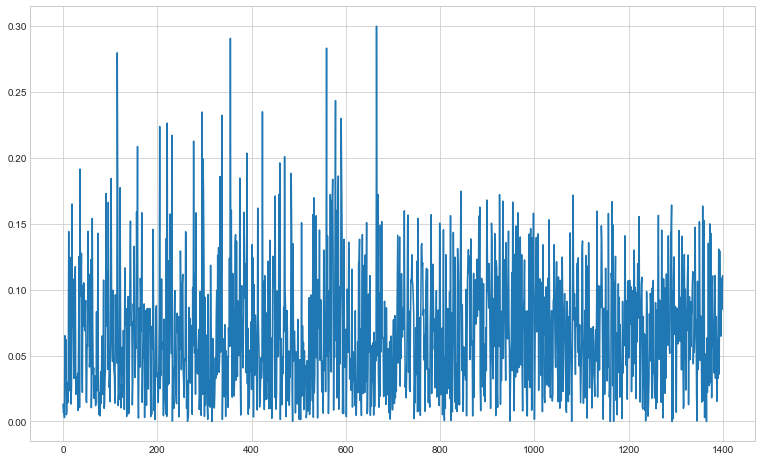

In [22]:
# 人工データの作成
seed=3
Data = tsModel.NeuralNet(p=7, q=0,  N=1400, random_seed=seed, sigma=2, model_random_seed=26, n_unit=[3,3], randomness="normal&uniform")
# print(tsModel.NeuralNet(p=7, q=1,  N=1400, random_seed=seed, sigma=2, model_random_seed=2, return_net=True).state_dict())
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
# plt.savefig(path+"/images/正規分布&一様分布でニューラルネットの人工データその{0}.png".format(seed))

In [23]:
original_window=50
target_window=50
dists4=[]

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1)
    dists4.append(dist)

正規分布＆移動ガンマ分布
ニューラル


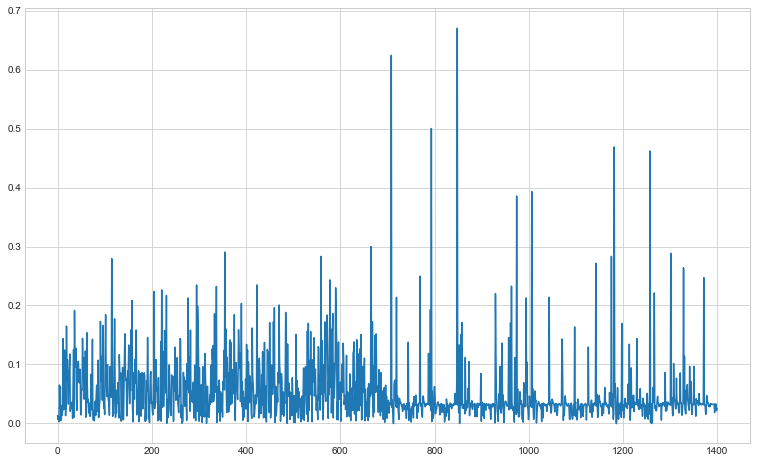

In [24]:
# 人工データの作成
seed=3
Data = tsModel.NeuralNet(p=7, q=0,  N=1400, random_seed=seed, sigma=2, model_random_seed=26, n_unit=[3,3], randomness="normal&gamma")
# print(tsModel.NeuralNet(p=7, q=1,  N=1400, random_seed=seed, sigma=2, model_random_seed=2, return_net=True).state_dict())
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
# plt.savefig(path+"/images/正規分布&移動ガンマ分布でニューラルネットの人工データその{0}.png".format(seed))

In [25]:
original_window=50
target_window=50
dists5=[]

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1)
    dists5.append(dist)

In [35]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists3, name="変化点なし", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists4, name="非線形 正規分布から一様分布", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists5, name="非線形 正規分布からガンマ分布", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="異常度の変化",
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,1400]},
                yaxis={"title":"value"},
                width = 1000,       # 全体のサイズ
                height = 600,
                )
)
plotly.offline.iplot(fig)

正規乱数
正規乱数


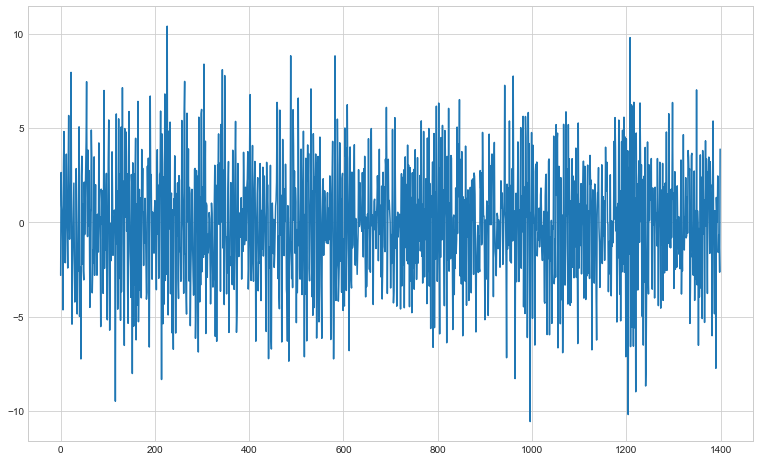

In [27]:
# 人工データの作成
seed=0
Data1 = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], m=12, D=0,phi=[-0.2,-0.4,0.2], N=700, random_seed=seed, sigma=2, randomness="normal")
Data2 = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], m=6, D=0,phi=[-0.2,-0.4,0.2], N=700, random_seed=seed, sigma=2, randomness="normal")
Data = np.concatenate([Data1, Data2])
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)

正規乱数
正規乱数


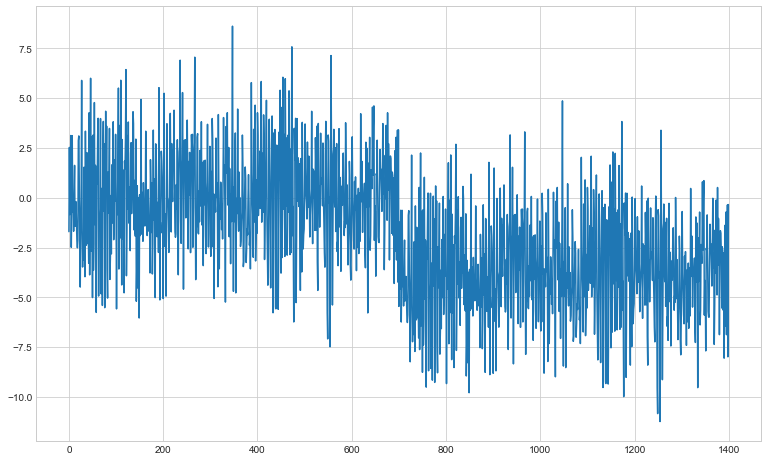

In [28]:
# 人工データの作成
seed=0
Data1 = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], N=700, random_seed=seed, sigma=2, randomness="normal")
Data2 = tsModel.SARIMA(a=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1], N=700, mu=-3, random_seed=seed, sigma=2, randomness="normal")
Data = np.concatenate([Data1, Data2])
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)

In [29]:
original_window=50
target_window=50
original = Data[:original_window]
dists6 = []

for i in range(original_window, len(Data)-target_window):
    target = Data[i:i+target_window]
    dist, cost_matrix, acc_cost_matrix = SSA_anom(test=target, traject=Data[:original_window], w=10, ncol_h=40, ncol_t=40, ns_h=3, ns_t=1, normalize=True)
    dists6.append(dist)

In [30]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=Data, name="時系列", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(original_window, len(Data)-target_window)), y=dists6, name="平均値の変化", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="DTWの変化",
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,1400]},
                yaxis={"title":"value"},
                width = 1000,       # 全体のサイズ
                height = 600,
                )
)
plotly.offline.iplot(fig)